In [1]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import numpy as np
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import scipy.io as sio
import random


In [2]:
random.seed(100)

dataset_path = r"Data/genres_original"
json_path = "data.json"
SAMPLE_RATE = 22050
DURATION = 29
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
hop_length = 512
n_mels = 200
expected_length = math.ceil(SAMPLES_PER_TRACK / hop_length)


In [3]:

def plot_history(hist):
    plt.figure(figsize=(25,  15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[0].grid()

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    axs[1].grid()

    plt.show()


# load data from json file
def load_data():
    # with open(dataset_path,"r") as f:
    #     data = json.load(f)
    #
    # # Convert list to numpy arrays
    # inputs = np.array(data["mfcc"])
    # targets = np.array(data["labels"])

    data = sio.loadmat("data.mat")
    inputs = data["mfcc"]
    targets = np.array(data["labels"])

    return inputs, targets


In [4]:
def prepare_dataset(test_size, validation_size):
    X, y = load_data()

    # for i in range(X.shape[1]):
    #     X[:,i,:] = X[:,i,:]/np.mean(X[:,i,:])

    y = y.reshape(-1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [5]:

X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(20, 1249, 1)


In [23]:
# build network topology
import tensorflow.keras as keras

model = keras.Sequential()

# 66%
# 1st conv layer
model.add(keras.layers.Conv2D(32, (3, 20), input_shape=input_shape, kernel_regularizer = regularizers.l2(1e-3) ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 30), strides=(2, 15), padding='same'))
model.add(keras.layers.Dropout(0.3))

# 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 16), kernel_regularizer = regularizers.l2(1e-3) ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 16), strides=(2, 8), padding='same'))
model.add(keras.layers.Dropout(0.3))

# 3rd conv layer
model.add(keras.layers.Conv2D(32, (2, 2), kernel_regularizer = regularizers.l2(1e-3) ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dropout(0.3))
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))

# # 1st conv layer
# model.add(keras.layers.Conv2D(20, (2, 40), strides=(1, 20), input_shape=input_shape, activity_regularizer=regularizers.L2(1e-5)))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.MaxPooling2D((1, 20), strides=(1, 20), padding='same'))
# model.add(keras.layers.Dropout(0.3))

# # 2nd conv layer
# model.add(keras.layers.Conv2D(10, (2, 2), strides = (1,1), activity_regularizer=regularizers.L2(1e-5)))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.MaxPooling2D((2, 2),strides = (1,1), padding='same'))
#
# # flatten output and feed it into dense layer
# model.add(keras.layers.Flatten())
# # model.add(keras.layers.Dense(10, activation='relu'))
# # # model.add(keras.layers.Dropout(0.3))
# #
# # # output layer
# model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 1230, 32)      1952      
                                                                 
 batch_normalization (BatchN  (None, 18, 1230, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 1230, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 82, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 9, 82, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 67, 32)         4

In [24]:
K.clear_session()
import glob
import shutil
import absl.logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # or any {'0', '1', '2'}


absl.logging.set_verbosity(absl.logging.ERROR)

save_model_path = 'CNN_models'

if not os.path.exists(save_model_path):
            os.mkdir(save_model_path)

if len(os.listdir(save_model_path)) != 0:
    # files = glob.glob(save_model_path)
    # for f in files:
    #     os.remove(f)
    shutil.rmtree(save_model_path)

cp = ModelCheckpoint(filepath='CNN_models', save_weights_only=False, monitor='val_accuracy',
                             mode='max', save_best_only=True)

# model.fit(self.X_train, self.y_train, batch_size=self.dictionary['batch_size'],
#                                  epochs=self.dictionary['epochs'], validation_data=(self.X_val, self.y_val),
#                                  verbose=1)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"] )

hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=400,
                 batch_size=70,
                 verbose = 2,
                 callbacks =cp)

Epoch 1/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 3s - loss: 3.1888 - accuracy: 0.1202 - val_loss: 5.3684 - val_accuracy: 0.1067 - 3s/epoch - 325ms/step
Epoch 2/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.4889 - accuracy: 0.1436 - val_loss: 3.3500 - val_accuracy: 0.1200 - 2s/epoch - 197ms/step
Epoch 3/400
9/9 - 1s - loss: 2.3282 - accuracy: 0.1786 - val_loss: 2.9265 - val_accuracy: 0.1200 - 557ms/epoch - 62ms/step
Epoch 4/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.2703 - accuracy: 0.1770 - val_loss: 2.5966 - val_accuracy: 0.1267 - 2s/epoch - 212ms/step
Epoch 5/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.2495 - accuracy: 0.1920 - val_loss: 2.3905 - val_accuracy: 0.1533 - 2s/epoch - 197ms/step
Epoch 6/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.1841 - accuracy: 0.2454 - val_loss: 2.2242 - val_accuracy: 0.1600 - 2s/epoch - 223ms/step
Epoch 7/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.1319 - accuracy: 0.2538 - val_loss: 2.1403 - val_accuracy: 0.1733 - 2s/epoch - 202ms/step
Epoch 8/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.1087 - accuracy: 0.2304 - val_loss: 2.0676 - val_accuracy: 0.2133 - 2s/epoch - 220ms/step
Epoch 9/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.0380 - accuracy: 0.2888 - val_loss: 2.0008 - val_accuracy: 0.2600 - 2s/epoch - 201ms/step
Epoch 10/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 2.0078 - accuracy: 0.2888 - val_loss: 1.9759 - val_accuracy: 0.2867 - 2s/epoch - 199ms/step
Epoch 11/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.9610 - accuracy: 0.3122 - val_loss: 1.9258 - val_accuracy: 0.3267 - 2s/epoch - 216ms/step
Epoch 12/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.9418 - accuracy: 0.3055 - val_loss: 1.8879 - val_accuracy: 0.3467 - 2s/epoch - 198ms/step
Epoch 13/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.9384 - accuracy: 0.2855 - val_loss: 1.8711 - val_accuracy: 0.3533 - 2s/epoch - 217ms/step
Epoch 14/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.8777 - accuracy: 0.3255 - val_loss: 1.8510 - val_accuracy: 0.3667 - 2s/epoch - 197ms/step
Epoch 15/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.8618 - accuracy: 0.3155 - val_loss: 1.8377 - val_accuracy: 0.3800 - 2s/epoch - 202ms/step
Epoch 16/400
9/9 - 1s - loss: 1.8199 - accuracy: 0.3656 - val_loss: 1.8147 - val_accuracy: 0.3533 - 549ms/epoch - 61ms/step
Epoch 17/400
9/9 - 1s - loss: 1.7964 - accuracy: 0.3573 - val_loss: 1.7845 - val_accuracy: 0.3267 - 549ms/epoch - 61ms/step
Epoch 18/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.7826 - accuracy: 0.3406 - val_loss: 1.7534 - val_accuracy: 0.3867 - 2s/epoch - 216ms/step
Epoch 19/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.7550 - accuracy: 0.3790 - val_loss: 1.7292 - val_accuracy: 0.4067 - 2s/epoch - 201ms/step
Epoch 20/400
9/9 - 1s - loss: 1.7205 - accuracy: 0.3923 - val_loss: 1.7183 - val_accuracy: 0.3933 - 557ms/epoch - 62ms/step
Epoch 21/400
9/9 - 1s - loss: 1.7258 - accuracy: 0.3539 - val_loss: 1.6674 - val_accuracy: 0.4067 - 566ms/epoch - 63ms/step
Epoch 22/400
9/9 - 1s - loss: 1.6371 - accuracy: 0.3940 - val_loss: 1.6612 - val_accuracy: 0.4067 - 565ms/epoch - 63ms/step
Epoch 23/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.6717 - accuracy: 0.3856 - val_loss: 1.6455 - val_accuracy: 0.4400 - 2s/epoch - 228ms/step
Epoch 24/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.6351 - accuracy: 0.4124 - val_loss: 1.6129 - val_accuracy: 0.4533 - 2s/epoch - 198ms/step
Epoch 25/400
9/9 - 1s - loss: 1.6287 - accuracy: 0.3923 - val_loss: 1.6755 - val_accuracy: 0.4400 - 548ms/epoch - 61ms/step
Epoch 26/400
9/9 - 1s - loss: 1.6017 - accuracy: 0.4357 - val_loss: 1.6828 - val_accuracy: 0.4200 - 595ms/epoch - 66ms/step
Epoch 27/400
9/9 - 1s - loss: 1.5904 - accuracy: 0.4207 - val_loss: 1.6717 - val_accuracy: 0.4333 - 596ms/epoch - 66ms/step
Epoch 28/400
9/9 - 1s - loss: 1.5823 - accuracy: 0.4073 - val_loss: 1.7169 - val_accuracy: 0.4200 - 584ms/epoch - 65ms/step
Epoch 29/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.6276 - accuracy: 0.4174 - val_loss: 1.6228 - val_accuracy: 0.4667 - 2s/epoch - 224ms/step
Epoch 30/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.4689 - accuracy: 0.4608 - val_loss: 1.5306 - val_accuracy: 0.4733 - 2s/epoch - 213ms/step
Epoch 31/400
9/9 - 1s - loss: 1.4871 - accuracy: 0.4441 - val_loss: 1.5948 - val_accuracy: 0.4067 - 579ms/epoch - 64ms/step
Epoch 32/400
9/9 - 1s - loss: 1.4872 - accuracy: 0.4641 - val_loss: 1.5923 - val_accuracy: 0.4200 - 614ms/epoch - 68ms/step
Epoch 33/400
9/9 - 1s - loss: 1.4203 - accuracy: 0.4775 - val_loss: 1.5055 - val_accuracy: 0.4667 - 579ms/epoch - 64ms/step
Epoch 34/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.4571 - accuracy: 0.4624 - val_loss: 1.4644 - val_accuracy: 0.5133 - 2s/epoch - 234ms/step
Epoch 35/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.3939 - accuracy: 0.4942 - val_loss: 1.4044 - val_accuracy: 0.5267 - 2s/epoch - 207ms/step
Epoch 36/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.3938 - accuracy: 0.4591 - val_loss: 1.4209 - val_accuracy: 0.5467 - 2s/epoch - 204ms/step
Epoch 37/400
9/9 - 1s - loss: 1.4151 - accuracy: 0.4925 - val_loss: 1.5066 - val_accuracy: 0.4600 - 574ms/epoch - 64ms/step
Epoch 38/400
9/9 - 1s - loss: 1.3951 - accuracy: 0.4841 - val_loss: 1.6087 - val_accuracy: 0.4133 - 644ms/epoch - 72ms/step
Epoch 39/400
9/9 - 1s - loss: 1.3821 - accuracy: 0.5092 - val_loss: 1.4128 - val_accuracy: 0.4800 - 603ms/epoch - 67ms/step
Epoch 40/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.3796 - accuracy: 0.5092 - val_loss: 1.4286 - val_accuracy: 0.5733 - 2s/epoch - 234ms/step
Epoch 41/400
9/9 - 1s - loss: 1.3016 - accuracy: 0.5092 - val_loss: 1.4734 - val_accuracy: 0.4533 - 579ms/epoch - 64ms/step
Epoch 42/400
9/9 - 1s - loss: 1.3527 - accuracy: 0.5175 - val_loss: 1.4720 - val_accuracy: 0.4600 - 658ms/epoch - 73ms/step
Epoch 43/400
9/9 - 1s - loss: 1.2642 - accuracy: 0.5309 - val_loss: 1.4138 - val_accuracy: 0.5400 - 636ms/epoch - 71ms/step
Epoch 44/400
9/9 - 1s - loss: 1.2944 - accuracy: 0.5326 - val_loss: 1.4155 - val_accuracy: 0.4933 - 641ms/epoch - 71ms/step
Epoch 45/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.2796 - accuracy: 0.5509 - val_loss: 1.3178 - val_accuracy: 0.6000 - 2s/epoch - 212ms/step
Epoch 46/400
9/9 - 1s - loss: 1.2805 - accuracy: 0.5776 - val_loss: 1.3269 - val_accuracy: 0.5400 - 595ms/epoch - 66ms/step
Epoch 47/400
9/9 - 1s - loss: 1.2467 - accuracy: 0.5559 - val_loss: 1.3790 - val_accuracy: 0.5000 - 673ms/epoch - 75ms/step
Epoch 48/400
9/9 - 1s - loss: 1.2907 - accuracy: 0.5459 - val_loss: 1.4385 - val_accuracy: 0.5200 - 653ms/epoch - 73ms/step
Epoch 49/400
9/9 - 1s - loss: 1.2152 - accuracy: 0.5793 - val_loss: 1.4470 - val_accuracy: 0.4600 - 623ms/epoch - 69ms/step
Epoch 50/400
9/9 - 1s - loss: 1.2147 - accuracy: 0.5476 - val_loss: 1.2914 - val_accuracy: 0.6000 - 662ms/epoch - 74ms/step
Epoch 51/400
9/9 - 1s - loss: 1.2691 - accuracy: 0.5643 - val_loss: 1.4270 - val_accuracy: 0.5400 - 652ms/epoch - 72ms/step
Epoch 52/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 1.2257 - accuracy: 0.5810 - val_loss: 1.3003 - val_accuracy: 0.6333 - 2s/epoch - 235ms/step
Epoch 53/400
9/9 - 1s - loss: 1.2198 - accuracy: 0.5810 - val_loss: 1.2936 - val_accuracy: 0.5467 - 611ms/epoch - 68ms/step
Epoch 54/400
9/9 - 1s - loss: 1.1358 - accuracy: 0.6093 - val_loss: 1.3324 - val_accuracy: 0.5267 - 657ms/epoch - 73ms/step
Epoch 55/400
9/9 - 1s - loss: 1.1663 - accuracy: 0.5977 - val_loss: 1.2253 - val_accuracy: 0.5667 - 673ms/epoch - 75ms/step
Epoch 56/400
9/9 - 1s - loss: 1.1841 - accuracy: 0.5810 - val_loss: 1.2470 - val_accuracy: 0.5867 - 673ms/epoch - 75ms/step
Epoch 57/400
9/9 - 1s - loss: 1.1570 - accuracy: 0.6077 - val_loss: 1.3535 - val_accuracy: 0.5267 - 671ms/epoch - 75ms/step
Epoch 58/400
9/9 - 1s - loss: 1.1374 - accuracy: 0.6127 - val_loss: 1.2843 - val_accuracy: 0.5400 - 672ms/epoch - 75ms/step
Epoch 59/400
9/9 - 1s - loss: 1.0949 - accuracy: 0.6227 - val_loss: 1.2809 - val_accuracy: 0.5733 - 661ms/epoch - 73ms/step
Epoch 60/400
9/9 - 1s -

INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 0.7717 - accuracy: 0.7362 - val_loss: 1.0588 - val_accuracy: 0.6733 - 2s/epoch - 222ms/step
Epoch 114/400
9/9 - 1s - loss: 0.6993 - accuracy: 0.7763 - val_loss: 1.4170 - val_accuracy: 0.5933 - 658ms/epoch - 73ms/step
Epoch 115/400
9/9 - 1s - loss: 0.6816 - accuracy: 0.7896 - val_loss: 1.1841 - val_accuracy: 0.6333 - 656ms/epoch - 73ms/step
Epoch 116/400
9/9 - 1s - loss: 0.7243 - accuracy: 0.7613 - val_loss: 1.1624 - val_accuracy: 0.6200 - 669ms/epoch - 74ms/step
Epoch 117/400
9/9 - 1s - loss: 0.7215 - accuracy: 0.7730 - val_loss: 1.2933 - val_accuracy: 0.5733 - 674ms/epoch - 75ms/step
Epoch 118/400
9/9 - 1s - loss: 0.7197 - accuracy: 0.7646 - val_loss: 1.4077 - val_accuracy: 0.5800 - 671ms/epoch - 75ms/step
Epoch 119/400
9/9 - 1s - loss: 0.6787 - accuracy: 0.7780 - val_loss: 1.5382 - val_accuracy: 0.5800 - 662ms/epoch - 74ms/step
Epoch 120/400
9/9 - 1s - loss: 0.6681 - accuracy: 0.7980 - val_loss: 1.2244 - val_accuracy: 0.6267 - 674ms/epoch - 75ms/step
Epoch 121/400
9/

INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 0.4559 - accuracy: 0.8664 - val_loss: 1.3908 - val_accuracy: 0.6800 - 2s/epoch - 234ms/step
Epoch 193/400
INFO:tensorflow:Assets written to: CNN_models\assets


INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 0.3868 - accuracy: 0.9115 - val_loss: 1.3720 - val_accuracy: 0.7067 - 2s/epoch - 243ms/step
Epoch 194/400
9/9 - 1s - loss: 0.4798 - accuracy: 0.8598 - val_loss: 1.3864 - val_accuracy: 0.7067 - 639ms/epoch - 71ms/step
Epoch 195/400
9/9 - 1s - loss: 0.5133 - accuracy: 0.8414 - val_loss: 1.8181 - val_accuracy: 0.5800 - 657ms/epoch - 73ms/step
Epoch 196/400
9/9 - 1s - loss: 0.4376 - accuracy: 0.8831 - val_loss: 1.5114 - val_accuracy: 0.5933 - 659ms/epoch - 73ms/step
Epoch 197/400
9/9 - 1s - loss: 0.4427 - accuracy: 0.8681 - val_loss: 1.5322 - val_accuracy: 0.6333 - 656ms/epoch - 73ms/step
Epoch 198/400
9/9 - 1s - loss: 0.4711 - accuracy: 0.8614 - val_loss: 1.3624 - val_accuracy: 0.6133 - 686ms/epoch - 76ms/step
Epoch 199/400
9/9 - 1s - loss: 0.4301 - accuracy: 0.8831 - val_loss: 1.3812 - val_accuracy: 0.6200 - 671ms/epoch - 75ms/step
Epoch 200/400
9/9 - 1s - loss: 0.5141 - accuracy: 0.8364 - val_loss: 1.7750 - val_accuracy: 0.5667 - 668ms/epoch - 74ms/step
Epoch 201/400
9/

INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 3s - loss: 0.2769 - accuracy: 0.9416 - val_loss: 1.3417 - val_accuracy: 0.7133 - 3s/epoch - 314ms/step
Epoch 322/400
9/9 - 1s - loss: 0.2527 - accuracy: 0.9549 - val_loss: 1.7642 - val_accuracy: 0.6133 - 617ms/epoch - 69ms/step
Epoch 323/400
9/9 - 1s - loss: 0.3014 - accuracy: 0.9265 - val_loss: 1.5430 - val_accuracy: 0.6800 - 693ms/epoch - 77ms/step
Epoch 324/400
9/9 - 1s - loss: 0.2807 - accuracy: 0.9382 - val_loss: 1.4555 - val_accuracy: 0.6533 - 679ms/epoch - 75ms/step
Epoch 325/400
9/9 - 1s - loss: 0.3148 - accuracy: 0.9249 - val_loss: 1.7513 - val_accuracy: 0.6067 - 692ms/epoch - 77ms/step
Epoch 326/400
9/9 - 1s - loss: 0.3308 - accuracy: 0.9199 - val_loss: 1.9177 - val_accuracy: 0.6467 - 664ms/epoch - 74ms/step
Epoch 327/400
9/9 - 1s - loss: 0.2868 - accuracy: 0.9332 - val_loss: 1.8141 - val_accuracy: 0.6133 - 712ms/epoch - 79ms/step
Epoch 328/400
9/9 - 1s - loss: 0.3431 - accuracy: 0.9282 - val_loss: 1.5581 - val_accuracy: 0.6467 - 706ms/epoch - 78ms/step
Epoch 329/400
9/

INFO:tensorflow:Assets written to: CNN_models\assets


9/9 - 2s - loss: 0.2863 - accuracy: 0.9499 - val_loss: 1.2569 - val_accuracy: 0.7200 - 2s/epoch - 255ms/step
Epoch 390/400
9/9 - 1s - loss: 0.2622 - accuracy: 0.9516 - val_loss: 1.2595 - val_accuracy: 0.7200 - 613ms/epoch - 68ms/step
Epoch 391/400
9/9 - 1s - loss: 0.2807 - accuracy: 0.9299 - val_loss: 1.4491 - val_accuracy: 0.7067 - 677ms/epoch - 75ms/step
Epoch 392/400
9/9 - 1s - loss: 0.2679 - accuracy: 0.9482 - val_loss: 1.7457 - val_accuracy: 0.6600 - 673ms/epoch - 75ms/step
Epoch 393/400
9/9 - 1s - loss: 0.2283 - accuracy: 0.9633 - val_loss: 2.0499 - val_accuracy: 0.6533 - 672ms/epoch - 75ms/step
Epoch 394/400
9/9 - 1s - loss: 0.2233 - accuracy: 0.9616 - val_loss: 1.6024 - val_accuracy: 0.6733 - 672ms/epoch - 75ms/step
Epoch 395/400
9/9 - 1s - loss: 0.2367 - accuracy: 0.9583 - val_loss: 1.5760 - val_accuracy: 0.6600 - 670ms/epoch - 74ms/step
Epoch 396/400
9/9 - 1s - loss: 0.2705 - accuracy: 0.9533 - val_loss: 1.4676 - val_accuracy: 0.6667 - 666ms/epoch - 74ms/step
Epoch 397/400
9/

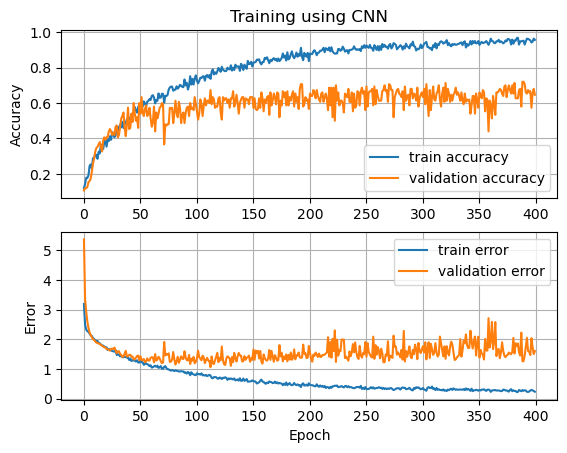

5/5 [==============================] - 0s 48ms/step - loss: 1.2569 - accuracy: 0.7200
Test accuracy: 0.7200000286102295


In [25]:
model = keras.models.load_model(save_model_path)

def plot_history(hist):
    # plt.figure(figsize=(30,  25))
    fig, axs = plt.subplots(2,1)

    axs[0].set_title("Training using CNN")
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    # axs[0].set_title("Accuracy")
    axs[0].grid()

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    # axs[1].set_title("Error")
    axs[1].grid()

    plt.show()


plot_history(hist)
test_error, test_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Test accuracy: {test_accuracy}")


In [26]:

def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")


# print(X_val.shape)
# print(X_train.shape)
predict(model, X_test[10], y_test[10])

1/1 [==============================] - 0s 63ms/step
Expected index: 5, Predicted index: [5]


In [7]:
save_model_path = 'CNN_models'
model = keras.models.load_model(save_model_path)

test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

8/8 [==============================] - 5s 13ms/step - loss: 0.4183 - accuracy: 0.9320
Test accuracy: 0.9319999814033508


8/8 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'Confusion Matrix for CNN classifier')

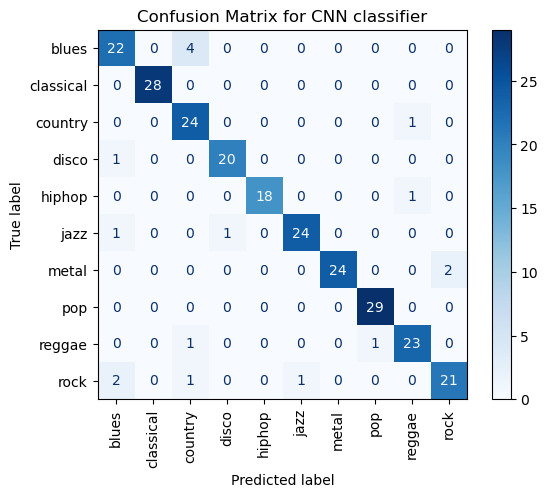

In [11]:
import sklearn
y_pred = np.argmax(model.predict(X_test), 1)
# print(y_pred)

labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
y_test_str = ['' for x in range(len(y_test))]
y_pred_str = ['' for x in range(len(y_pred))]

# for i in range(len(y_test)):
#     y_test_str[i] = labels[y_test[i]]
#     y_pred_str[i] = labels[y_pred[i]]

# print(y_test_pred)
cf = sklearn.metrics.confusion_matrix(y_test, y_pred, sample_weight=None, normalize=None)
plot = sklearn.metrics.ConfusionMatrixDisplay(cf, display_labels=labels )
plot.plot(cmap='Blues', xticks_rotation = 'vertical')
plt.title('Confusion Matrix for CNN classifier')